<a href="https://www.kaggle.com/code/adelinmil/pg-s03e23-quick-and-dirty-implementation?scriptVersionId=148092274" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install nb-black==1.0.5 --quiet

%load_ext lab_black

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 23.2 which is incompatible.
jupyterlab-lsp 4.2.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.2 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.


In [2]:
import pandas as pd
import numpy as np

SEED = 42

# ploting
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 6)

# CV
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

# metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

# Hyperparameters Tuning
import optuna

# Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# Handle Imbalance
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings

warnings.filterwarnings("ignore")

# <center> [PG S03E23 | EDA](https://www.kaggle.com/code/adelinmil/pg-s03e23-eda)

In [3]:
tr = pd.read_csv(
    "/kaggle/input/playground-series-s3e23/train.csv",
    usecols=lambda x: x != "id",
    dtype={"defects": int},
)
ts = pd.read_csv("/kaggle/input/playground-series-s3e23/test.csv")

test_ids = ts.pop("id")

In [4]:
X, y = tr.drop("defects", axis=1), tr["defects"]

In [5]:
xgb_params = {
    "objective": "binary:logistic",
    "tree_method": "hist",
    "colsample_bytree": 0.7,
    "gamma": 2,
    "learning_rate": 0.01,
    "max_depth": 7,
    "min_child_weight": 10,
    "n_estimators": 500,
    "subsample": 0.7,
    "random_state": SEED,
    "n_jobs": -1,
}

lgbm_params = {
    "n_estimators": 767,
    "learning_rate": 0.007508264910364354,
    "num_leaves": 49,
    "scale_pos_weight": 2,
    "random_state": SEED,
    "n_jobs": -1,
}

cat_params = {
    "iterations": 908,
    "learning_rate": 0.06140047846870991,
    "depth": 4,
    "subsample": 0.6647503738606261,
    "colsample_bylevel": 0.552723130653578,
    "min_data_in_leaf": 39,
    "random_state": SEED,
    "verbose": False,
}

hist_params = {
    "random_state": SEED,
}

rf_params = {
    "n_estimators": 500,
    "max_depth": 7,
    "min_samples_split": 15,
    "min_samples_leaf": 10,
    "random_state": SEED,
    "n_jobs": -1,
}

etc_params = {
    "random_state": SEED,
    "n_jobs": -1,
}

lr_params = {
    "random_state": SEED,
    "n_jobs": -1,
    "max_iter": 5_000,
}

In [6]:
tmp_estimators = [
    ("lgbm", LGBMClassifier(**lgbm_params)),
    ("cat", CatBoostClassifier(**cat_params)),
    ("hist", HistGradientBoostingClassifier(**hist_params)),
    ("xgb", XGBClassifier(**xgb_params)),
    ("etc", ExtraTreesClassifier(**etc_params)),
    ("rf", RandomForestClassifier(**rf_params)),
    ("lr", LogisticRegression(**lr_params)),
]

kf = StratifiedKFold(n_splits=10, random_state=SEED, shuffle=True)

In [7]:
def Validate(X, y, estimator, cv=kf):
    val_predictions = np.zeros((len(X)))
    val_scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        model = clone(estimator)

        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)

        train_preds = model.predict_proba(X_train)[:, 1]
        val_preds = model.predict_proba(X_val)[:, 1]

        val_predictions[val_idx] += val_preds

        val_score = roc_auc_score(y_val, val_preds)

        val_scores.append(val_score)

    return val_scores, val_predictions

In [8]:
def experiment(X, y, COMMENT):
    score_list, oof_list = pd.DataFrame(), pd.DataFrame()

    estimators = [
        ("lgbm", LGBMClassifier(**lgbm_params)),
        ("cat", CatBoostClassifier(**cat_params)),
        ("hist", HistGradientBoostingClassifier(**hist_params)),
        ("xgb", XGBClassifier(**xgb_params)),
        ("etc", ExtraTreesClassifier(**etc_params)),
        ("rf", RandomForestClassifier(**rf_params)),
        ("lr", LogisticRegression(**lr_params)),
    ]

    for name, clf in estimators:
        label = clf.__class__.__name__
        score_list[label], oof_list[label] = Validate(
            X,
            y,
            estimator=clf,
        )

    scores = pd.Series(score_list.mean(), name="roc_auc_score").sort_values()

    with plt.style.context("dark_background"):
        ax = sns.barplot(x=scores.values, y=scores.index)
        ax.set_title(COMMENT, fontsize=20)
        ax.bar_label(ax.containers[0], fontsize=12)
        plt.show()

    return score_list, oof_list

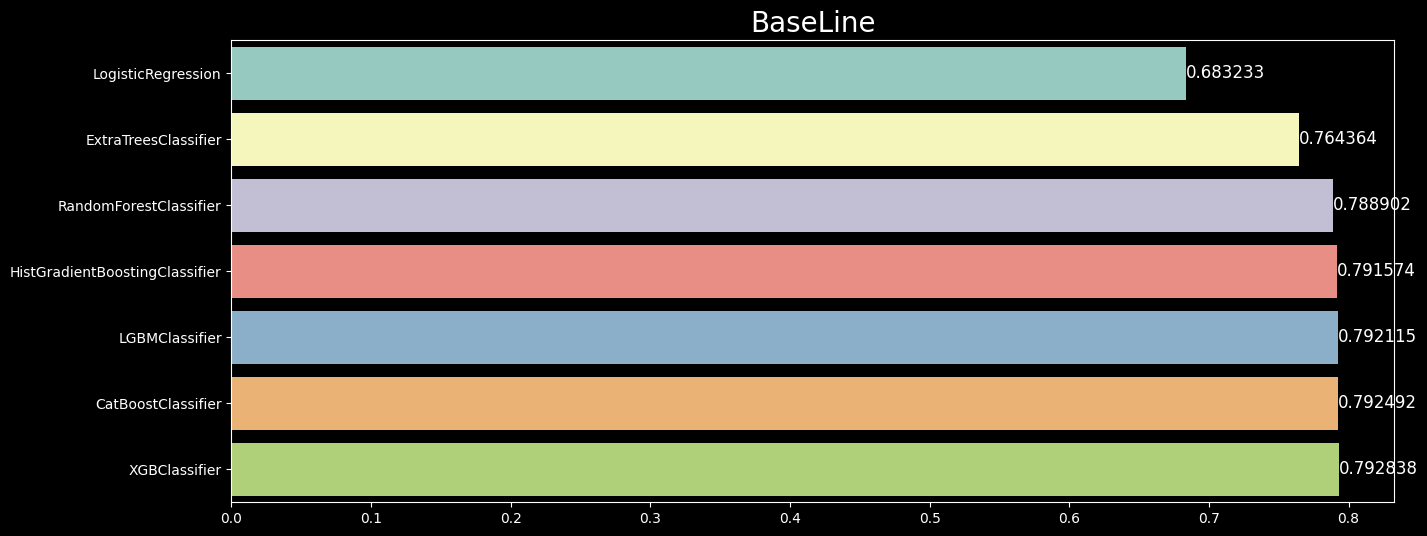

In [9]:
score_list, oof_list = experiment(X, y, "BaseLine")

In [10]:
df = pd.concat([X.copy(), ts], axis=0).reset_index(drop=True)

df['mean_bnv']         = (df['n'] + df['v'] + df['b']) /3;
df['mean_uniqOpOpend'] = (df['uniq_Op'] + df['uniq_Opnd']) /2;
df['mean_totOpOpend']  = (df['total_Op'] + df['total_Opnd']) /2;
df['mean_brcntvg']     = (df['branchCount'] + df['v(g)']) / 2;

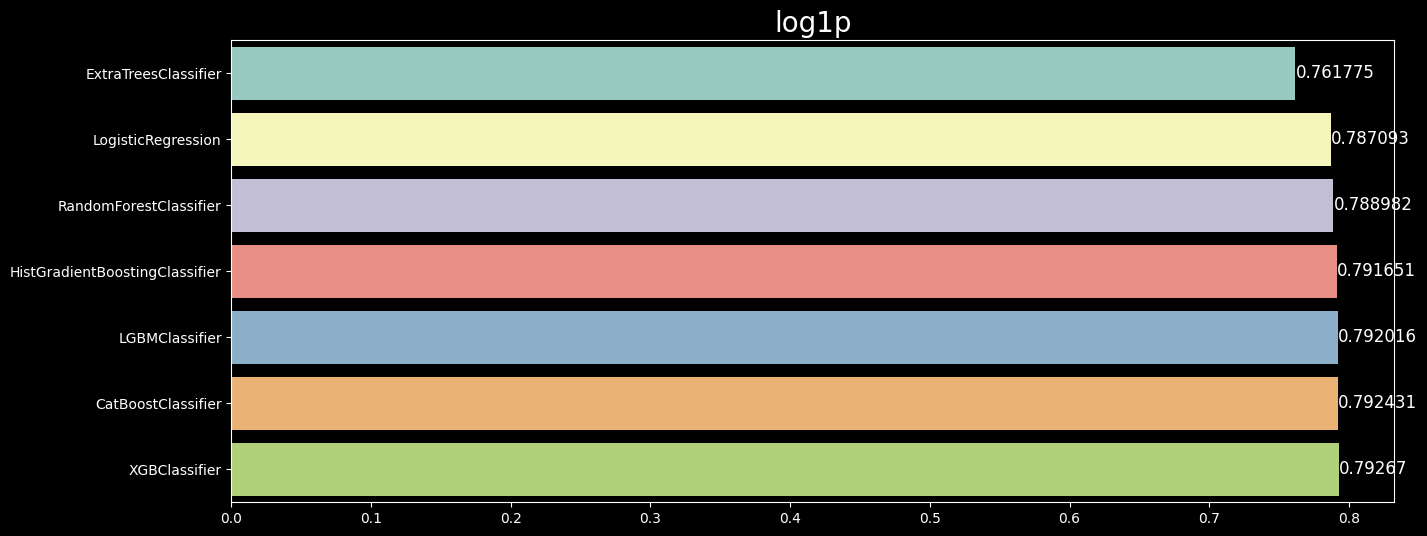

In [11]:
for column in df.columns:
    df[column] = df[column].apply(lambda x: np.log1p(x))

X_new = df.iloc[: len(X)]
ts = df.iloc[len(X) :]

score_list, oof_list = experiment(X_new, y, "log1p")

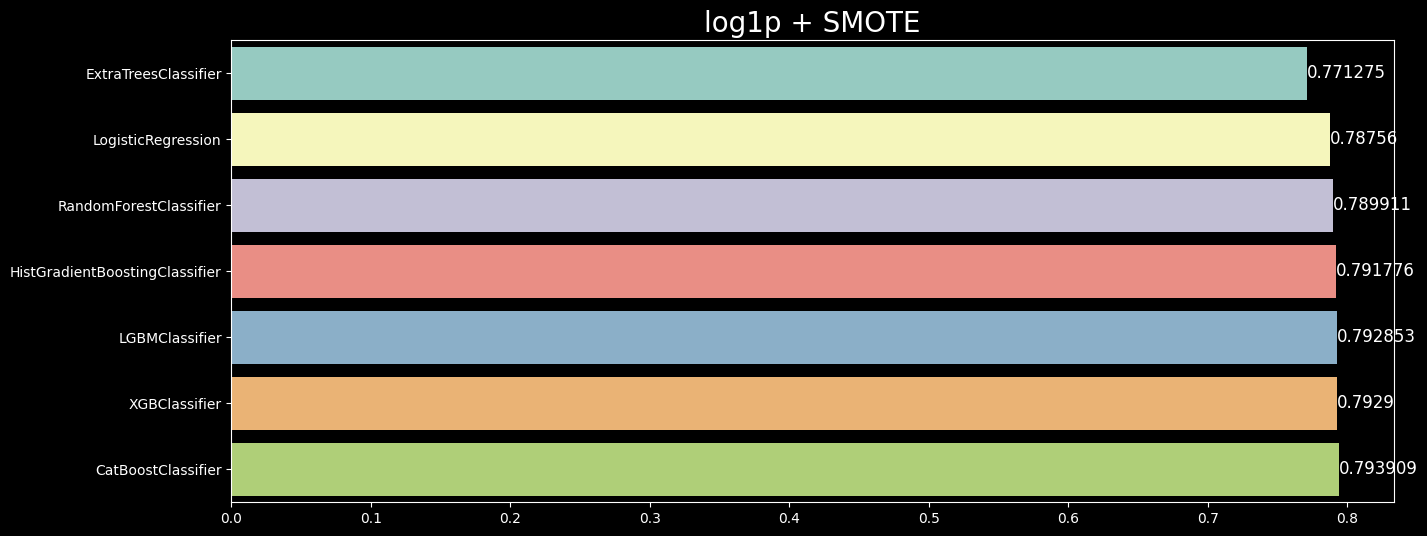

In [12]:
over = SMOTE(sampling_strategy=0.3, random_state=SEED)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=SEED)
steps = [("o", over), ("u", under)]
pipeline = Pipeline(steps=steps)

os_X, os_y = pipeline.fit_resample(X_new, y)

score_list, oof_list = experiment(os_X, os_y, "log1p + SMOTE")

In [13]:
weights = RidgeClassifier(random_state = SEED).fit(oof_list, os_y).coef_[0]

pd.DataFrame(weights, index = list(oof_list), columns = ['weight per model'])

,weight per model
LGBMClassifier,0.264534
CatBoostClassifier,1.321879
HistGradientBoostingClassifier,-0.053237
XGBClassifier,0.235108
ExtraTreesClassifier,0.269383
RandomForestClassifier,-0.114139
LogisticRegression,0.083772


In [14]:
eclf = VotingClassifier(
    estimators=tmp_estimators,
    voting="soft",
    weights=weights,
)


scores = cross_val_score(eclf, os_X, os_y, scoring="roc_auc", cv=kf, n_jobs=-1)
print(f"{eclf.__class__.__name__} auroc score: {scores.mean()}")

VotingClassifier auroc score: 0.7950556203887353


In [15]:
eclf.fit(os_X, os_y)
submission = pd.DataFrame(
    {"id": test_ids, "defects": pd.Series(eclf.predict_proba(ts)[:, 1])}
)
submission.head()

,id,defects
0,101763,0.371726
1,101764,0.313554
2,101765,0.773492
3,101766,0.612477
4,101767,0.274664


In [16]:
submission.to_csv("submission.csv", index=False)

# <center> <span style="color:orange"> If You Find This Notebook Helpful Please Consider Upvoting and Sharing.